# Will it be delayed?

Everyone who has flown has experienced a delayed or cancelled flight. Both airlines and airports would like to improve their on-time performance and predict when a flight will be delayed or cancelled several days in advance. You are being hired to build a model that can predict if a flight will be delayed. To learn more, you must schedule a meeting with your client (me). To schedule an appointment with your client, send an event request through Google Calendar for a 15 minute meeting. Both you and your project partner must attend the meeting. Come prepared with questions to ask your client. Remember that your client is not a data scientist and you will need to explain things in a way that is easy to understand. Make sure that your communications are efficient, thought out, and not redundant as your client might get frustrated and "fire" you (this only applies to getting information from your client, this does not necessary apply to asking for help with the actual project itself - you should continuously ask questions for getting help).

For this project you must go through most all steps in the checklist. You must write responses for all items as done in the homeworks, however sometimes the item will simply be "does not apply". Keep your progress and thoughts organized in this document and use formatting as appropriate (using markdown to add headers and sub-headers for each major part). Some changes to the checklist:

* Do not do the final part (launching the product).
* Your presentation will be done as information written in this document in a dedicated section (no slides or anything like that). It should include high-level summary of your results (including what you learned about the data, the "accuracy" of your model, what features were important, etc). It should be written for your client, not your professor or teammates. It should include the best summary plots/graphics/data points.
* The models and hyperparameters you should consider during short-listing and fine-tuning will be released at a later time (dependent on how far we get over the next two weeks).
* Data retrieval must be automatic as part of the code (so it can easily be re-run and grab the latest data). Do not commit any data to the repository.
* Your submission must include a pickled final model along with this notebook.

# **Frame the Problem and Look at the Big Picture**  

#### **1. Define the Objective in Business Terms**  
Airlines and airports experience frequent flight delays and cancellations, leading to passenger dissatisfaction and operational inefficiencies. The goal of this project is to develop a **multiclass classification model** that can **predict flight delays or cancellations** **7 days in advance**. The ability to predict disruptions early allows airlines to:  
- Reallocate aircraft and crew.  
- Notify passengers and offer rebooking options.  
- Optimize airport operations and prevent cascading delays.  

This project will focus on **domestic U.S. flights** and will exclude **international and diverted flights** to maintain consistency in the dataset.  

#### **2. How Will the Solution Be Used?**  
- The model will be run **daily**, providing updated predictions on which flights are likely to experience delays or cancellations.  
- Airlines can integrate the predictions into their **scheduling and rebooking systems**, enabling proactive customer communication.  
- Airports can use this data to **allocate ground resources efficiently** and manage air traffic congestion.  

#### **3. What Are the Current Solutions/Workarounds (If Any)?**  
- Currently, airlines and airports rely on **historical trends, weather forecasts, and real-time operational data** to predict delays.  
- Most delay tracking is **reactive**—flights are only flagged **after** they experience a disruption.  
- Government agencies such as the **Bureau of Transportation Statistics (BTS)** track flight performance, but their reports are **only available months after the fact**.  

#### **4. How Should You Frame This Problem?**  
This is a **supervised multiclass classification problem** since we are predicting a categorical outcome (on-time, minor delay, medium delay, major delay, or cancelled).  
- The model will be trained on historical flight data, with **flight status (delay/cancellation) as the target variable**. 
- under 15 delay ignore, 15-60 mins is minor, medium 60 mins-3 hours, major above 3 hour with combinations to reasoning of delay
- Since the model is used for forecasting rather than real-time decision-making, it does **not** need to be deployed in a real-time system.  
- The dataset consists of flight records from **2023 and newer**, sourced from **BTS and OpenFlights**.  

#### **5. How Should Performance Be Measured? Is the Performance Measure Aligned with the Business Objective?**  
*This will be determined later based on model evaluation metrics such as accuracy, precision, recall, or F1-score.*  

#### **6. What Would Be the Minimum Performance Needed to Reach the Business Objective?**  
*This will be a TBD for now*  

#### **7. What Are Comparable Problems? Can You Reuse (Personal or Readily Available) Experience or Tools?**  
- Similar approaches have been used in **weather-dependent demand forecasting** for airlines and ride-sharing services.  
- Predicting delays has been studied using **time-series forecasting** and **classification models** in previous airline research.  
- Past experience working with **the California Housing dataset** and **other classification problems** will be useful for feature engineering and model evaluation.  

#### **8. Is Human Expertise Available?**  
- Airlines employ **operations researchers and flight dispatchers** who have domain knowledge on **delay causes**.  
- The BTS dataset provides **historical justifications for past delays**, which can guide feature selection.  
- While expert input is valuable, the model will primarily rely on **data-driven predictions**.  

#### **9. How Would You Solve the Problem Manually?**  
If solving this problem manually, one could:  
1. **Analyze past trends**: Identify which flights and routes are most prone to delays.  
2. **Review seasonal patterns**: Account for peak travel times, weather conditions, and airport congestion.  
3. **Use airline reports**: Check for maintenance schedules, pilot shortages, or operational disruptions.  
4. **Compare historical and real-time data**: Look for signs of delays such as **late-arriving aircraft, bad weather, or air traffic control restrictions**.  

These insights will guide **feature selection and model training**.  


#### **10. List the Assumptions You (or Others) Have Made So Far. Verify Assumptions if Possible.**  
- **Assumption:** Delay and cancellation patterns remain **consistent** over time (i.e., historical delays are predictive of future delays).  
- **Assumption:** Only domestic flights are included, as international flights have **different regulations and factors** affecting delays.  
- **Assumption:** Some external factors (like **weather**) may not be necessary for accurate predictions.  
- **Verification Plan:** Test models **with and without** weather data to determine its importance in delay prediction.  

# **Get the Data**  

#### **1. List the Data You Need and How Much You Need**  
- **Flight performance data (delays, cancellations)** from **2023 and newer**.  
- **Airport and airline metadata** (e.g., number of employees, aircraft details).  
- **National air system and security data** affecting flight schedules.  
- **Holiday schedules**, as travel spikes influence delays.  

#### **2. Find and Document Where You Can Get That Data**  
- **Flight delay data**: [Bureau of Transportation Statistics (BTS)](https://www.transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FGK&QO_fu146_anzr=b0-gvzr)  
- **Airport data**: [OpenFlights dataset](https://openflights.org/data.php)  
- **Holiday schedules**: Manually compiled from government sources.  

#### **3. Get Access Authorizations**  
- BTS flight data is **publicly available**.  
- OpenFlights data is **open-source**.  
- Holiday schedules are obtained from **public records**.  

#### **4. Create a Workspace**  
- All processing will be done in a **Jupyter Notebook** or similar data science environment.  

#### **5. Get the Data**  
- Use **automated scripts** to download BTS flight data.  
- Load and clean **OpenFlights data** to merge airport metadata.  

#### **6. Convert the Data to a Format You Can Easily Manipulate**  
- Convert flight data into a **structured DataFrame**.  
- Merge external datasets (airport information, holidays).  
- Format timestamps and categorical variables appropriately.  

In [14]:
# imports for this project 
import pandas as pd
import os
from glob import glob
from datetime import datetime, timedelta
import holidays
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [15]:
def merge_flight_data(directory: str) -> pd.DataFrame:
    """
    Loads and merges all CSV files from the specified directory into a single DataFrame.
    Assumes each CSV has the same structure.
    
    Parameters:
    directory (str): Path to the directory containing CSV files.

    Returns:
    pd.DataFrame: Merged DataFrame with datetime formatting.
    """
    # Get all CSV files in the directory
    csv_files = glob(os.path.join(directory, "*.csv"))
    
    if not csv_files:
        raise ValueError("No CSV files found in the directory.")

    # Load and concatenate all CSV files
    df_list = [pd.read_csv(file, low_memory=False) for file in csv_files]
    merged_df = pd.concat(df_list, ignore_index=True)
    
    # Convert FlightDate to datetime format
    if "FlightDate" in merged_df.columns:
        merged_df["FlightDate"] = pd.to_datetime(merged_df["FlightDate"], errors='coerce')

    return merged_df

def clean_flight_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Removes unnecessary columns related to diverted flights from the flight dataset.

    Parameters:
    df (pd.DataFrame): Merged flight dataset.

    Returns:
    pd.DataFrame: Cleaned DataFrame without diverted flight columns.
    """
    columns_to_drop = [
        "DivAirportLandings", "DivReachedDest", "DivActualElapsedTime", "DivArrDelay", "DivDistance",
        "Div1Airport", "Div1AirportID", "Div1AirportSeqID", "Div1WheelsOn", "Div1TotalGTime", 
        "Div1LongestGTime", "Div1WheelsOff", "Div1TailNum", "Div2Airport", "Div2AirportID", 
        "Div2AirportSeqID", "Div2WheelsOn", "Div2TotalGTime", "Div2LongestGTime", "Div2WheelsOff", 
        "Div2TailNum", "Div3Airport", "Div3AirportID", "Div3AirportSeqID", "Div3WheelsOn", 
        "Div3TotalGTime", "Div3LongestGTime", "Div3WheelsOff", "Div3TailNum", "Div4Airport", 
        "Div4AirportID", "Div4AirportSeqID", "Div4WheelsOn", "Div4TotalGTime", "Div4LongestGTime", 
        "Div4WheelsOff", "Div4TailNum", "Div5Airport", "Div5AirportID", "Div5AirportSeqID", 
        "Div5WheelsOn", "Div5TotalGTime", "Div5LongestGTime", "Div5WheelsOff", "Div5TailNum"
    ]
    
    # Drop columns that exist in the DataFrame (to avoid errors if some are missing)
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

    return df

def drop_international_flights(flight_df: pd.DataFrame) -> pd.DataFrame:
    """
    Removes international flights by keeping only flights where both the origin and destination
    are within U.S. states.

    Parameters:
    flight_df (pd.DataFrame): Flight dataset containing 'OriginState' and 'DestState'.

    Returns:
    pd.DataFrame: Filtered dataset with only domestic U.S. flights.
    """
    # List of all valid U.S. state abbreviations
    us_states = set([
        "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS",
        "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY",
        "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV",
        "WI", "WY"
    ])

    # Filter for domestic flights (both origin and destination should be in US states)
    domestic_flights = flight_df[
        flight_df["OriginState"].isin(us_states) & flight_df["DestState"].isin(us_states)
    ]

    print(f"Dropped {len(flight_df) - len(domestic_flights)} international flights.")
    return domestic_flights

def load_airport_data():
    """
    Downloads and processes the OpenFlights airport dataset.
    
    Returns:
    pd.DataFrame: Cleaned airport dataset with IATA, Latitude, and Longitude.
    """
    url = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat"

    # Column names for OpenFlights dataset
    columns = ["AirportID", "Name", "City", "Country", "IATA", "ICAO", "Lat", "Lon", "Altitude",
               "Timezone", "DST", "TzDatabaseTimeZone", "Type", "Source"]

    # Load only required columns: IATA, Lat, Lon
    airport_df = pd.read_csv(url, header=None, names=columns, usecols=["IATA", "Lat", "Lon"])

    # Ensure IATA codes are strings and clean whitespace
    airport_df["IATA"] = airport_df["IATA"].astype(str).str.strip()

    return airport_df


def merge_airport_coordinates(flight_df: pd.DataFrame) -> pd.DataFrame:
    """
    Merges airport latitude & longitude for both Origin and Destination airports
    using OpenFlights data.

    Parameters:
    flight_df (pd.DataFrame): Flight dataset containing 'Origin' and 'Dest' (IATA Codes).

    Returns:
    pd.DataFrame: Flight dataset with 'Origin_Lat', 'Origin_Lon', 'Dest_Lat', 'Dest_Lon' added.
    """
    # Load airport data
    airport_df = load_airport_data()

    # Ensure IATA codes are strings and clean whitespace
    flight_df["Origin"] = flight_df["Origin"].astype(str).str.strip()
    flight_df["Dest"] = flight_df["Dest"].astype(str).str.strip()
    airport_df["IATA"] = airport_df["IATA"].astype(str).str.strip()

    # Rename OpenFlights IATA column for easier merging
    iata_airport_df = airport_df.rename(columns={"IATA": "Dest"})  

    # Merge with flight data on Origin (IATA Code) for departure airport coordinates
    flight_df = flight_df.merge(
        airport_df[['IATA', 'Lat', 'Lon']], 
        left_on="Origin", 
        right_on="IATA", 
        how="left"
    ).rename(columns={"Lat": "Origin_Lat", "Lon": "Origin_Lon"}).drop(columns=["IATA"])

    # Merge with flight data on Dest (IATA Code) for destination airport coordinates
    if "Dest" in flight_df.columns:
        flight_df = flight_df.merge(
            iata_airport_df[['Dest', 'Lat', 'Lon']], 
            on="Dest", 
            how="left"
        ).rename(columns={"Lat": "Dest_Lat", "Lon": "Dest_Lon"})
    else:
        print("Warning: 'Dest' column not found in flight data!")

    return flight_df

def load_aircraft_data(filepath: str) -> pd.DataFrame:
    """
    Loads the aircraft dataset from a CSV file.
    
    Parameters:
    filepath (str): Path to the aircraft data CSV file.
    
    Returns:
    pd.DataFrame: Processed aircraft dataset.
    """
    aircraft_df = pd.read_csv(filepath)
    
    # Ensure necessary columns exist
    required_columns = {"reg", "airlineName", "model", "modelCode", "numSeats", 
                        "typeName", "numEngines", "engineType", "isFreighter", "ageYears"}
    
    missing_cols = required_columns - set(aircraft_df.columns)
    if missing_cols:
        raise ValueError(f"Missing columns in aircraft data: {missing_cols}")

    return aircraft_df

def merge_aircraft_data(flight_df: pd.DataFrame, aircraft_df: pd.DataFrame) -> pd.DataFrame:
    """
    Merges aircraft metadata with the flight dataset using the Tail_Number column.

    Parameters:
    flight_df (pd.DataFrame): The main flight dataset containing 'Tail_Number'.
    aircraft_df (pd.DataFrame): The aircraft dataset containing 'reg' (registration number).

    Returns:
    pd.DataFrame: Flight dataset with aircraft information merged.
    """
    # Ensure both columns are strings and remove whitespace
    flight_df["Tail_Number"] = flight_df["Tail_Number"].astype(str).str.strip()
    aircraft_df["reg"] = aircraft_df["reg"].astype(str).str.strip()

    # Select relevant aircraft columns to merge
    aircraft_df_selected = aircraft_df[[
        "reg", "airlineName", "model", "modelCode", "numSeats", "typeName", 
        "numEngines", "engineType", "isFreighter", "ageYears"
    ]]

    aircraft_df_selected = aircraft_df_selected.rename(columns={
        "reg": "Tail_Number",
        "airlineName": "Aircraft_Airline",
        "model": "Aircraft_Model",
        "modelCode": "Aircraft_ModelCode",
        "numSeats": "Aircraft_Seats",
        "typeName": "Aircraft_Type",
        "numEngines": "Aircraft_Engines",
        "engineType": "Aircraft_EngineType",
        "isFreighter": "Is_Freighter",
        "ageYears": "Aircraft_Age"
    })

    # Merge the flight data with aircraft data on Tail_Number
    merged_df = flight_df.merge(aircraft_df_selected, on="Tail_Number", how="left")

    return merged_df

def generate_us_holiday_data(start_year: int, end_year: int) -> pd.DataFrame:
    """
    Generates a dataset of major U.S. holidays and includes the week before each holiday.

    Parameters:
    start_year (int): The starting year for holiday data.
    end_year (int): The ending year for holiday data.

    Returns:
    pd.DataFrame: A DataFrame containing holiday dates and their corresponding holiday week.
    """
    # Get U.S. holidays for the specified years
    us_holidays = holidays.US(years=range(start_year, end_year + 1))

    # Define major holidays that should be considered
    major_holidays = [
        "New Year's Day", "Martin Luther King Jr. Day", "Presidents' Day",
        "Memorial Day", "Independence Day", "Labor Day",
        "Columbus Day", "Veterans Day", "Thanksgiving", "Christmas Day"
    ]

    # Create a list to store holiday records
    holiday_data = []

    for date, name in sorted(us_holidays.items()):
        if name in major_holidays:
            holiday_date = datetime.strptime(str(date), "%Y-%m-%d")

            # Generate the entire holiday week (7 days leading up to the holiday)
            for i in range(-7, 1):
                holiday_week_date = holiday_date + timedelta(days=i)
                holiday_data.append({
                    "Holiday": name,
                    "Holiday_Date": holiday_date,
                    "Week_Date": holiday_week_date,
                    "Is_Holiday_Week": 1
                })

    # Convert to DataFrame
    holiday_df = pd.DataFrame(holiday_data)

    return holiday_df

def merge_holiday_data(flight_df: pd.DataFrame, holiday_df: pd.DataFrame) -> pd.DataFrame:
    """
    Merges holiday data with the flight dataset based on FlightDate, ensuring all flights are retained.

    Parameters:
    flight_df (pd.DataFrame): The flight dataset containing 'FlightDate'.
    holiday_df (pd.DataFrame): The holiday dataset containing 'Week_Date', 'Is_Holiday_Week', and 'Holiday'.

    Returns:
    pd.DataFrame: Flight dataset with holiday week indicator and holiday name.
    """
    # Convert FlightDate and Week_Date to datetime format (if not already)
    flight_df = flight_df.copy()
    holiday_df = holiday_df.copy()
    
    flight_df["FlightDate"] = pd.to_datetime(flight_df["FlightDate"], errors="coerce")
    holiday_df["Week_Date"] = pd.to_datetime(holiday_df["Week_Date"], errors="coerce")

    # Create a lookup dictionary for holiday weeks
    holiday_week_dict = holiday_df.set_index("Week_Date")["Is_Holiday_Week"].to_dict()
    holiday_name_dict = holiday_df.set_index("Week_Date")["Holiday"].to_dict()

    # Map holiday week and holiday name to the flight data without merging
    flight_df["Is_Holiday_Week"] = flight_df["FlightDate"].map(holiday_week_dict).fillna(0).astype(int)
    flight_df["Holiday"] = flight_df["FlightDate"].map(holiday_name_dict).fillna("None")

    return flight_df

def create_flight_status(df: pd.DataFrame) -> pd.DataFrame:
    """
    Creates the target variable 'Flight_Status' based on delay categories.

    Parameters:
    df (pd.DataFrame): The dataset containing delay information.

    Returns:
    pd.DataFrame: The dataset with 'Flight_Status' column added.
    """
    df = df.copy()

    # Define delay categories based on arrival delay
    df["Flight_Status"] = "On-Time"
    df.loc[df["ArrDelayMinutes"] >= 15, "Flight_Status"] = "Minor Delay"
    df.loc[df["ArrDelayMinutes"] >= 60, "Flight_Status"] = "Medium Delay"
    df.loc[df["ArrDelayMinutes"] >= 180, "Flight_Status"] = "Major Delay"
    df.loc[df["Cancelled"] == 1, "Flight_Status"] = "Cancelled"

    return df

def stratified_random_split(df: pd.DataFrame, target_column: str, test_size: float = 0.1, random_state: int = 42):
    """
    Performs a stratified random train-test split to ensure all classes in 
    'Flight_Status' are proportionally represented in both sets.

    Parameters:
    df (pd.DataFrame): The dataset containing the target variable.
    target_column (str): The column representing the classification target.
    test_size (float): The proportion of data to be used as test data.
    random_state (int): Random seed for reproducibility.

    Returns:
    tuple: (train_df, test_df) DataFrames.
    """
    train_df, test_df = train_test_split(
        df, test_size=test_size, stratify=df[target_column], random_state=random_state
    )

    print(f"Train size: {len(train_df)} samples")
    print(f"Test size: {len(test_df)} samples")
    
    # Verify class distributions
    print("\nTrain Class Distribution:")
    print(train_df[target_column].value_counts(normalize=True) * 100)
    
    print("\nTest Class Distribution:")
    print(test_df[target_column].value_counts(normalize=True) * 100)

    return train_df, test_df

# weather data will be needed using coordinates of the airports

In [ ]:
aircraft_data = load_aircraft_data("aircrafts.csv")
holiday_data = generate_us_holiday_data(2023, 2025)
data = merge_flight_data("./FlightData")
data = clean_flight_data(data)
data = drop_international_flights(data)
data = merge_airport_coordinates(data)
data = merge_aircraft_data(data, aircraft_data)
data = merge_holiday_data(data, holiday_data)
flight_data = create_flight_status(data)

Dropped 176807 international flights.


In [4]:
data

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,...,Aircraft_Model,Aircraft_ModelCode,Aircraft_Seats,Aircraft_Type,Aircraft_Engines,Aircraft_EngineType,Is_Freighter,Aircraft_Age,Is_Holiday_Week,Holiday
0,2023,4,12,30,6,2023-12-30,DL,DL_CODESHARE,19790,DL,...,CRJ9,CRJ-900LR,NaN,Canadair CRJ 900,2.0,Jet,False,17.1,1,New Year's Day
1,2023,4,12,30,6,2023-12-30,DL,DL_CODESHARE,19790,DL,...,CRJ9,CRJ-900LR,NaN,Canadair CRJ 900,2.0,Jet,False,17.1,1,New Year's Day
2,2023,4,12,1,5,2023-12-01,DL,DL_CODESHARE,19790,DL,...,CRJ9,CRJ-900LR,76.0,Canadair CRJ 900,2.0,Jet,False,NaN,0,None
3,2023,4,12,3,7,2023-12-03,DL,DL_CODESHARE,19790,DL,...,CRJ9,CRJ-900LR,76.0,Canadair CRJ 900,2.0,Jet,False,17.4,0,None
4,2023,4,12,4,1,2023-12-04,DL,DL_CODESHARE,19790,DL,...,CRJ9,CRJ-900LR,NaN,Canadair CRJ 900,2.0,Jet,False,17.3,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14648895,2024,3,9,11,3,2024-09-11,DL,DL,19790,DL,...,A319,319-114,132.0,Airbus A319,2.0,Jet,False,22.4,0,None
14648896,2024,3,9,11,3,2024-09-11,DL,DL,19790,DL,...,A319,319-114,132.0,Airbus A319,2.0,Jet,False,22.4,0,None
14648897,2024,3,9,12,4,2024-09-12,DL,DL,19790,DL,...,A319,319-114,132.0,Airbus A319,2.0,Jet,False,22.4,0,None
14648898,2024,3,9,12,4,2024-09-12,DL,DL,19790,DL,...,A319,319-114,132.0,Airbus A319,2.0,Jet,False,22.4,0,None


In [5]:
# pd.set_option('display.max_columns', None)
# print(data.head())

In [7]:
flight_data = create_flight_status(data)

In [8]:
flight_data

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,...,Aircraft_ModelCode,Aircraft_Seats,Aircraft_Type,Aircraft_Engines,Aircraft_EngineType,Is_Freighter,Aircraft_Age,Is_Holiday_Week,Holiday,Flight_Status
0,2023,4,12,30,6,2023-12-30,DL,DL_CODESHARE,19790,DL,...,CRJ-900LR,NaN,Canadair CRJ 900,2.0,Jet,False,17.1,1,New Year's Day,On-Time
1,2023,4,12,30,6,2023-12-30,DL,DL_CODESHARE,19790,DL,...,CRJ-900LR,NaN,Canadair CRJ 900,2.0,Jet,False,17.1,1,New Year's Day,On-Time
2,2023,4,12,1,5,2023-12-01,DL,DL_CODESHARE,19790,DL,...,CRJ-900LR,76.0,Canadair CRJ 900,2.0,Jet,False,NaN,0,None,On-Time
3,2023,4,12,3,7,2023-12-03,DL,DL_CODESHARE,19790,DL,...,CRJ-900LR,76.0,Canadair CRJ 900,2.0,Jet,False,17.4,0,None,Minor Delay
4,2023,4,12,4,1,2023-12-04,DL,DL_CODESHARE,19790,DL,...,CRJ-900LR,NaN,Canadair CRJ 900,2.0,Jet,False,17.3,0,None,On-Time
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14648895,2024,3,9,11,3,2024-09-11,DL,DL,19790,DL,...,319-114,132.0,Airbus A319,2.0,Jet,False,22.4,0,None,On-Time
14648896,2024,3,9,11,3,2024-09-11,DL,DL,19790,DL,...,319-114,132.0,Airbus A319,2.0,Jet,False,22.4,0,None,On-Time
14648897,2024,3,9,12,4,2024-09-12,DL,DL,19790,DL,...,319-114,132.0,Airbus A319,2.0,Jet,False,22.4,0,None,On-Time
14648898,2024,3,9,12,4,2024-09-12,DL,DL,19790,DL,...,319-114,132.0,Airbus A319,2.0,Jet,False,22.4,0,None,Major Delay


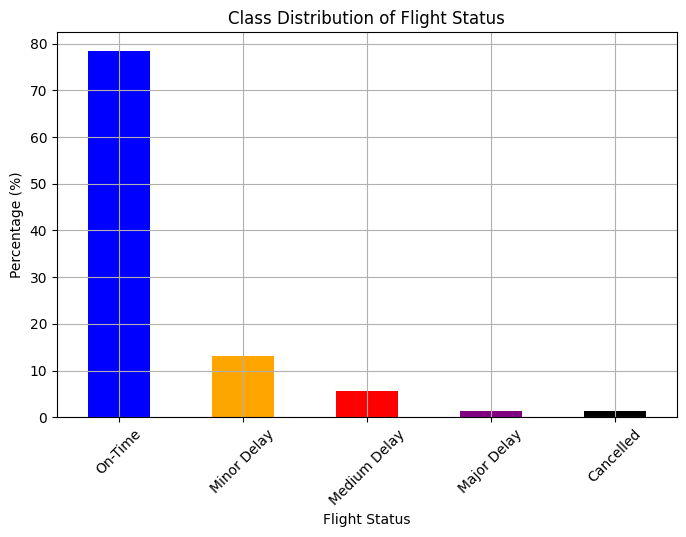

In [10]:
def plot_class_distribution(df: pd.DataFrame, target_column: str):
    """
    Plots the distribution of the target variable.

    Parameters:
    df (pd.DataFrame): The dataset containing the target variable.
    target_column (str): The column representing the classification target.

    Returns:
    None
    """
    class_counts = df[target_column].value_counts(normalize=True) * 100
    class_counts.plot(kind="bar", figsize=(8, 5), color=["blue", "orange", "red", "purple", "black"])
    plt.title("Class Distribution of Flight Status")
    plt.xlabel("Flight Status")
    plt.ylabel("Percentage (%)")
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

plot_class_distribution(flight_data, target_column="Flight_Status")


In [16]:
train_data, test_data = stratified_random_split(flight_data, target_column="Flight_Status")

Train size: 13184010 samples
Test size: 1464890 samples

Train Class Distribution:
Flight_Status
On-Time         78.541749
Minor Delay     13.174057
Medium Delay     5.591220
Major Delay      1.363273
Cancelled        1.329702
Name: proportion, dtype: float64

Test Class Distribution:
Flight_Status
On-Time         78.541734
Minor Delay     13.174027
Medium Delay     5.591205
Major Delay      1.363311
Cancelled        1.329724
Name: proportion, dtype: float64
